In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


In [5]:
df=pd.read_csv('daily_covid_cases.csv')
train_size = int(len(df) * 0.65)
train, test = df.iloc[:train_size], df.iloc[train_size:]


Processing AR(1) model...
AR(1) - RMSE: 5663.92, MAPE: 3.45%

Processing AR(5) model...
AR(5) - RMSE: 1923.59, MAPE: 1.57%

Processing AR(10) model...
AR(10) - RMSE: 1776.81, MAPE: 1.52%

Processing AR(15) model...
AR(15) - RMSE: 1699.23, MAPE: 1.50%

Processing AR(20) model...
AR(20) - RMSE: 1929.46, MAPE: 1.60%

Processing AR(25) model...
AR(25) - RMSE: 1795.64, MAPE: 1.54%

Processing AR(30) model...
AR(30) - RMSE: 1802.59, MAPE: 1.58%

Processing AR(35) model...
AR(35) - RMSE: 1821.69, MAPE: 1.61%

Processing AR(40) model...
AR(40) - RMSE: 1802.46, MAPE: 1.64%

Processing AR(45) model...
AR(45) - RMSE: 1800.53, MAPE: 1.65%

Processing AR(50) model...
AR(50) - RMSE: 1816.26, MAPE: 1.81%

Processing AR(55) model...
AR(55) - RMSE: 1828.12, MAPE: 1.86%

Processing AR(60) model...
AR(60) - RMSE: 1860.87, MAPE: 2.02%


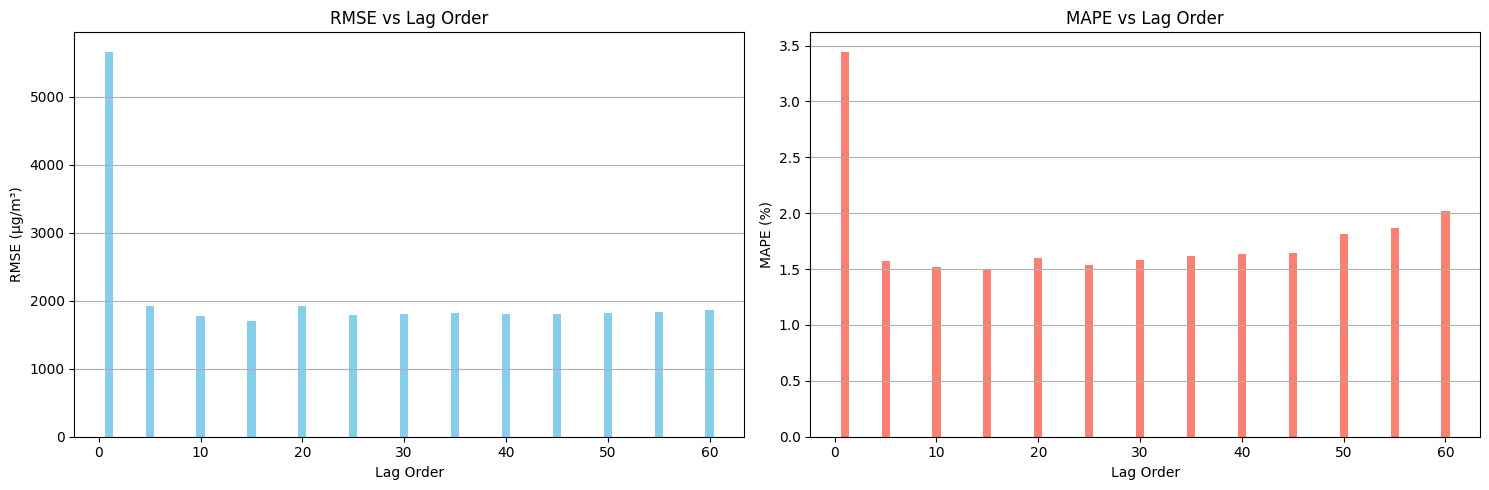

In [16]:
lags = [1, 5, 10, 15, 20, 25, 30,35, 40, 45, 50, 55, 60]

results = []

for p in lags:
    print(f"\nProcessing AR({p}) model...")
    
    try:
        # Train model with trend='c' for constant term
        model = AutoReg(train['new_cases'], lags=p, trend='c', old_names=False).fit()
        coef = model.params
        
        # Make predictions
        history = train['new_cases'].values.tolist()
        predictions = []
        
        for t in range(len(test)):
            lag_values = history[-p:] if len(history) >= p else [np.mean(history)]*p
            yhat = coef.iloc[0] + sum(coef.iloc[i+1] * lag_values[p-i-1] for i in range(p))
            predictions.append(yhat)
            history.append(test['new_cases'].iloc[t])
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(test['new_cases'], predictions))
        
        # Robust MAPE calculation
        with np.errstate(divide='ignore', invalid='ignore'):
            ape = np.abs((test['new_cases'] - predictions) / test['new_cases'])
            ape = ape.replace([np.inf, -np.inf], np.nan).dropna()
            mape = np.mean(ape) * 100 if len(ape) > 0 else float('nan')
        
        results.append({
            'lag': p,
            'rmse': rmse,
            'mape': mape,
            'predictions': predictions,
            'model': model
        })
        
        print(f"AR({p}) - RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
        
    except Exception as e:
        print(f"Failed for AR({p}): {str(e)}")
        results.append({
            'lag': p,
            'rmse': np.nan,
            'mape': np.nan,
            'predictions': None,
            'model': None
        })
results_df = pd.DataFrame(results).dropna()

# Visualization
if not results_df.empty:
    # 3. Performance metrics by lag
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # RMSE plot
    ax1.bar(results_df['lag'], results_df['rmse'], color='skyblue')
    ax1.set_title("RMSE vs Lag Order")
    ax1.set_xlabel("Lag Order")
    ax1.set_ylabel("RMSE (µg/m³)")
    ax1.grid(True, axis='y')    
    # MAPE plot
    ax2.bar(results_df['lag'], results_df['mape'], color='salmon')
    ax2.set_title("MAPE vs Lag Order")
    ax2.set_xlabel("Lag Order")
    ax2.set_ylabel("MAPE (%)")
    ax2.grid(True, axis='y')

    
    plt.tight_layout()
    plt.show()

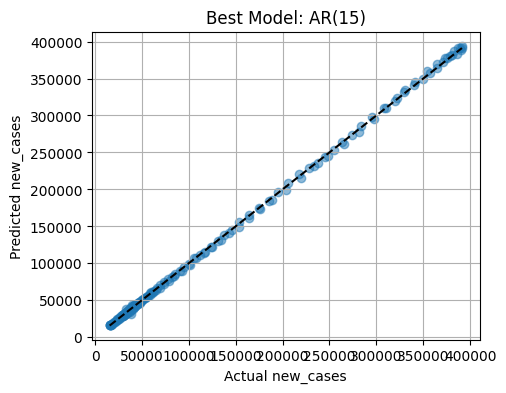

In [10]:
# Visualization
if not results_df.empty:
    # Find best model (lowest RMSE)
    best_idx = results_df['rmse'].idxmin()
    
    # 1. Scatter plot
    plt.figure(figsize=(5, 4))
    plt.scatter(test['new_cases'], results_df.loc[best_idx, 'predictions'], alpha=0.5)
    plt.plot([test['new_cases'].min(), test['new_cases'].max()], 
             [test['new_cases'].min(), test['new_cases'].max()], 'k--')
    plt.title(f"Best Model: AR({results_df.loc[best_idx, 'lag']})")
    plt.xlabel("Actual new_cases")
    plt.ylabel("Predicted new_cases")
    plt.grid(True)
    plt.show()
    

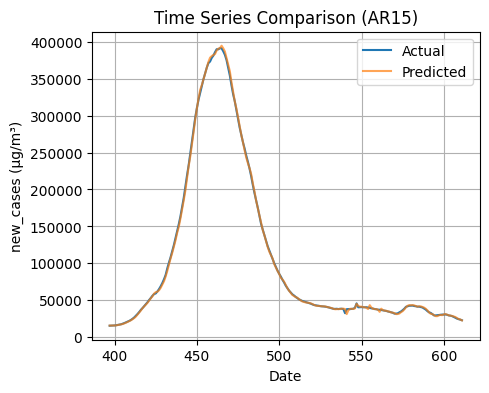

In [12]:
    # 2. Time series comparison
    plt.figure(figsize=(5, 4))
    plt.plot(test.index.to_numpy(), test['new_cases'].to_numpy(), label='Actual')
    plt.plot(test.index.to_numpy(), np.array(results_df.loc[best_idx, 'predictions']), label='Predicted', alpha=0.7)
    plt.title(f"Time Series Comparison (AR{results_df.loc[best_idx, 'lag']})")
    plt.xlabel("Date")
    plt.ylabel("new_cases (µg/m³)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
print("\nPerformance Summary:")
print(results_df[['lag', 'rmse', 'mape']].to_string(index=False))


Performance Summary:
 lag        rmse     mape
   1 5663.923460 3.446540
   5 1923.589814 1.574836
  10 1776.812841 1.519370
  15 1699.230025 1.496236
  20 1929.462304 1.601514
  25 1795.639508 1.535421
  30 1802.592723 1.578048
  35 1821.689711 1.613949
  40 1802.462199 1.635602
  45 1800.527435 1.648497
  50 1816.258137 1.811298
  55 1828.120398 1.863506
  60 1860.865711 2.021643
